In [ ]:
# %%bash
# cd /StudentData
# function gdrive_download () {
#     CONFIRM=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=$1" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')
#     wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$CONFIRM&id=$1" -O $2
#     rm -rf /tmp/cookies.txt
# }
# gdrive_download 1U_wlpp_A_GFa24lZRuwqqNz5lv4Sw7yN train.tar
# gdrive_download 1k-njgb8xXrp72pQv7k-Ro3foxJRtLWLr test.tar
# tar -xf train.tar
# tar -xf test.tar

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms, utils
import torchvision.datasets as dsets
from sklearn.metrics import f1_score
from skimage import io, transform
import matplotlib.image as mpimg
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import warnings
import torch
import time
import os

warnings.filterwarnings("ignore")

In [2]:
def to_gpu(x):
    return x.cuda() if torch.cuda.is_available() else x

# Define Data Loading

In [3]:
class costum_images_dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, sorted(os.listdir(self.root_dir))[idx])
        image = io.imread(img_name)
        label = img_name[-5] # get the label of a given image
        sample = (image, int(label))

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample[0], sample[1] 

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return (img, label)


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample[0], sample[1] 

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left: left + new_w]
        return (image, label)

    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample[0], sample[1] 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1)).astype(float)
        return (torch.from_numpy(image), torch.tensor(label))

In [10]:
train_dataset = costum_images_dataset(root_dir='/StudentData/train/', transform=transforms.Compose([Rescale((32,32)),ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 512, shuffle=True, num_workers=2)

test_dataset = costum_images_dataset(root_dir='/StudentData/test/', transform=transforms.Compose([Rescale((32,32)),ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 512, shuffle=False, num_workers=2)

# Define Network #1

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU())
        self.layer25 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(4 * 4 * 256, 2) # 4*4*256, 2
        self.dropout = nn.Dropout(p=0.2)
        self.logsoftmax = nn.LogSoftmax()
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer25(out) 
        out = self.layer2(out) 
#         out = self.dropout(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         out = self.dropout(out)
        out = self.layer5(out) 
        out = out.view(out.size(0), -1)  
#         out = self.dropout(out)
        out = self.fc(out) 

        return self.softmax(out)

In [10]:
cnn = CNN()
cnn = to_gpu(cnn)

criterion = nn.NLLLoss()
criterion = to_gpu(criterion)

print('number of parameters: ', sum(param.numel() for param in cnn.parameters()))
print(f'Num of trainable parameters : {sum(p.numel() for p in cnn.parameters() if p.requires_grad)}')

number of parameters:  402770
Num of trainable parameters : 402770


# Model Training

In [11]:
my_max_model = to_gpu(CNN())
my_max_score = 95.07

In [29]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=0.001)

train_errors_per_epoch = []
train_loss_per_epoch = []
train_f1_per_epoch = []

test_errors_per_epoch = []
test_loss_per_epoch = []
test_f1_per_epoch = []

for epoch in range(10):
    start = time.time()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = to_gpu(images)
        labels = to_gpu(labels)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        images = images.float()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    #end of epoch
    cnn.eval() 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = to_gpu(images)
        images = images.float()
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    print(time.time() - start, ' epoch is:', epoch+1 , 'Test Accuracy of the model is:', float((100 * correct.item() / total)))
    if  float((100 * correct.item() / total)) > my_max_score:
        my_max_score = float((100 * correct.item() / total))
        my_max_model = cnn
    
    #train
    correct = 0
    total = 0    
    y_pred = []
    y_true = []
    for images, labels in train_loader:
        images = to_gpu(images)
        images = images.float()
        labels = to_gpu(labels)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        y_pred += [x.item() for x in predicted] # save all predictions
        y_true += [x.item() for x in labels] # save all true values
    
    train_loss_per_epoch.append(epoch_loss / len(train_loader )) # save loss so far
    train_errors_per_epoch.append( 1 - float(correct.item()) / float(total)) # save error so far
    train_f1_per_epoch.append(f1_score(y_true, y_pred, average='binary'))  # save f1 so far
    
    
    #test
    temp_test_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = to_gpu(images)
        images = images.float()
        labels = to_gpu(labels)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        loss = criterion(outputs, labels)
        temp_test_loss += loss.item()
        y_pred += [x.item() for x in predicted] # save all predictions
        y_true += [x.item() for x in labels] # save all true values
        
    test_loss_per_epoch.append(float(temp_test_loss)/float(len(test_loader)))  # save loss so far
    test_errors_per_epoch.append( 1 -  float(correct.item()) / float(total)) # save error so far
    test_f1_per_epoch.append(f1_score(y_true, y_pred, average='binary')) # save f1 so far

290.8878891468048  epoch is: 1 Test Accuracy of the model is: 84.29181728557344
304.2421898841858  epoch is: 2 Test Accuracy of the model is: 90.00985869208019
294.1089060306549  epoch is: 3 Test Accuracy of the model is: 91.07788366743345
287.8298451900482  epoch is: 4 Test Accuracy of the model is: 92.0308905685179
288.57837414741516  epoch is: 5 Test Accuracy of the model is: 92.17877094972067
288.2446298599243  epoch is: 6 Test Accuracy of the model is: 92.37594479132436
292.67113876342773  epoch is: 7 Test Accuracy of the model is: 92.70456786066381
298.5642294883728  epoch is: 8 Test Accuracy of the model is: 92.75386132106473
292.27025961875916  epoch is: 9 Test Accuracy of the model is: 92.35951363785738
294.10697317123413  epoch is: 10 Test Accuracy of the model is: 92.60598093986198


In [11]:
#torch.save(cnn.state_dict(), 'cnn_best_v1.pkl')

# Plot Graphs

### Errors per Epoch

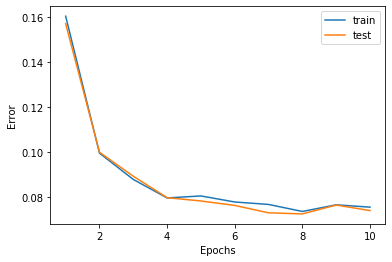

In [30]:
epoch_list = list(range(1,10 + 1))

plt.plot(epoch_list,train_errors_per_epoch, label='train')
plt.plot(epoch_list,test_errors_per_epoch,label='test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

### Loss per Epoch

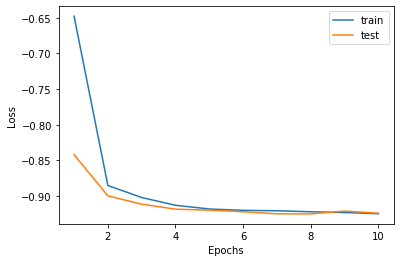

In [31]:
plt.plot(epoch_list,train_loss_per_epoch, label='train')
plt.plot(epoch_list,test_loss_per_epoch,label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### F1 per Epoch

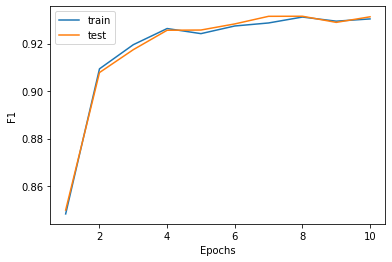

In [32]:
plt.plot(epoch_list,train_f1_per_epoch, label='train')
plt.plot(epoch_list,test_f1_per_epoch, label='test')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

### ROC AUC CURVE

In [33]:
from sklearn import metrics
import matplotlib.pyplot as plt

#ROC for train data
y_prob = []
y_true = []
for images, labels in train_loader:
    images = to_gpu(images)
    images = images.float()
    labels = to_gpu(labels)
    outputs = cnn(images)
    y_prob += outputs.tolist() # save all predictions
    y_true += [x.item() for x in labels] # save all true values

In [34]:
#ROC for test data
y_test_prob = []
y_test_true = []
for images, labels in test_loader:
    images = to_gpu(images)
    images = images.float()
    labels = to_gpu(labels)
    outputs = cnn(images)
    y_test_prob += outputs.tolist() # save all predictions
    y_test_true += [x.item() for x in labels] # save all true values

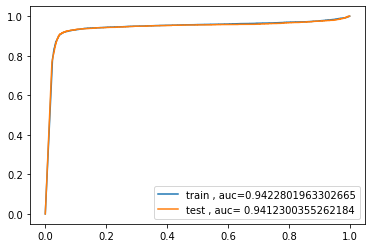

In [35]:
fpr, tpr, _ = metrics.roc_curve(y_true, [x[1] for x in y_prob])
auc = metrics.roc_auc_score(y_true,  [x[1] for x in y_prob])
plt.plot(fpr,tpr,label="train , auc=" + str(auc))

fpr_t, tpr_t, _ = metrics.roc_curve(y_test_true, [x[1] for x in y_test_prob])
auc_t = metrics.roc_auc_score(y_test_true,  [x[1] for x in y_test_prob])
plt.plot(fpr_t, tpr_t,label="test , auc= " + str(auc_t))

plt.legend(loc=4)
plt.show()